<div class='bar_title'></div>

*Smart Cities and Geospatial Data Analysis*

# Spatial Regression Analysis

__Gunther Gust__ <br>
Chair for Enterprise AI <br>
Data Driven Decisions (D3) Group<br>
Center for Artificial Intelligence and Data Science (CAIDAS)

Winter Semester 23/24

<img src="images/d3.png" style="width:20%; float:left;" />

<img src="images/CAIDASlogo.png" style="width:20%; float:left;" />

# Content

* Recap: Conventional (non-spatial) Regression
* Regression Models for Spatial Heterogeneity 
* Regression Models for Spatial Dependence



*Credits: Most of the material is taken from [Rey et al (2023): Geographic Data Science with Python](https://geographicdata.science/book/intro.html)*

# Why Spatial Regression Models?

Explain or predict phenomena for which __geography matters__

## A) The process that generates the data is spatial

Examples:
* __House prices__ are higher closer to the city center
* __Covid 19 infections__ spread accross space


## B) There are spatial associations in the data (even though we might not know why)

Examples:
* __Spatial structure in our errors:__ geography should be an attribute somehow, but we are not sure how to include it in our model
    * Some other __ommitted feature__ causes spatial patterns in the error
    * __Interactions and interdependencies__ between included features cause spatial patterns in the error

Overall, regardless of whether or not the true process is explicitly geographic, additional information about the __spatial relationships__ between our observations or more information about nearby sites can make our __predictions better.__

Regression (and prediction more generally) provides us a perfect case to examine how spatial structure can help us understand and analyze our data. In this chapter, we discuss how spatial structure can be used to both validate and improve prediction algorithms, focusing on linear regression specifically. 

## *What* is spatial regression and *why* should I care?

Usually, spatial structure helps regression models in one of two ways. 
The first (and most clear) way space can have an impact on our data is when the process *generating* the data is itself explicitly spatial.
Here, think of something like the prices for single family homes. 
It's often the case that individuals pay a premium on their house price in order to live in a better school district for the same quality house. 
Alternatively, homes closer to noise or chemical polluters like waste water treatment plants, recycling facilities, or wide highways, may actually be cheaper than we would otherwise anticipate. 
In cases like asthma incidence, the locations individuals tend to travel to throughout the day, such as their places of work or recreation, may have more impact on their health than their residential addresses. 
In this case, it may be necessary to use data *from other sites* to predict the asthma incidence at a given site. 
Regardless of the specific case at play, here, *geography is a feature*: it directly helps us make predictions about outcomes *because those outcomes are obtained from geographical processes*. 

An alternative (and more skeptical understanding) reluctantly acknowledges geography's instrumental value. 
Often, in the analysis of predictive methods and classifiers, we are interested in analyzing what we get wrong.
This is common in econometrics; an analyst may be concerned that the model *systematically* mis-predicts some types of observations.
If we know our model routinely performs poorly on a known set of observations or type of input, we might make a better model if we can account for this. 
Among other kinds of error diagnostics, geography provides us with an exceptionally useful embedding to assess structure in our errors.
Mapping classification/prediction error can help show whether or not there are *clusters of error* in our data.
If we *know* that errors tend to be larger in some areas than in other areas (or if error is "contagious" between observations), then we might be able to exploit this structure to make better predictions.

Spatial structure in our errors might arise from when geography *should be* an attribute somehow, but we are not sure exactly how to include it in our model. 
They might also arise because there is some *other* feature whose omission causes the spatial patterns in the error we see; if this additional feature were included, the structure would disappear. 
Or, it might arise from the complex interactions and interdependencies between the features that we have chosen to use as predictors, resulting in intrinsic structure in mis-prediction. 
Most of the predictors we use in models of social processes contain *embodied* spatial information: patterning intrinsic to the feature that we get for free in the model. 
If we intend to or not, using a spatially patterned predictor in a model can result in spatially patterned errors; using more than one can amplify this effect. 
Thus, *regardless of whether or not the true process is explicitly geographic*, additional information about the spatial relationships between our observations or more information about nearby sites can make our predictions better. 

In this chapter, we build space into the traditional regression framework. We begin with a standard linear regression model, devoid of any geographical reference. From there, we formalize space and spatial relationships in three main ways: first, encoding it in exogenous variables; second, through spatial heterogeneity, or as systematic variation of outcomes across space; third, as dependence, or through the effect associated to the characteristics of spatial neighbors. Throughout, we focus on the conceptual differences each approach entails rather than on the technical details.



In [189]:
#%pip install geopandas seaborn contextily pysal

## Task: Predict San Diego Airbnb Prices



To learn a little more about how regression works, we'll examine information about Airbnb properties in San Diego, CA. 
This dataset contains house intrinsic characteristics, both continuous (number of beds as in `beds`) and categorical (type of renting or, in Airbnb jargon, property group as in the series of `pg_X` binary variables), but also variables that explicitly refer to the location and spatial configuration of the dataset (e.g., distance to Balboa Park, `d2balboa` or neighborhood id, `neighborhood_cleansed`).

In [190]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import contextily

import warnings
#warnings.filterwarnings("ignore")

In [191]:
db =  geopandas.read_file("https://raw.githubusercontent.com/GuntherGust/sc_gdsa_data/main/regression_db.geojson")

These are the explanatory variables we will use throughout the chapter.

In [192]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

In [193]:
db.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


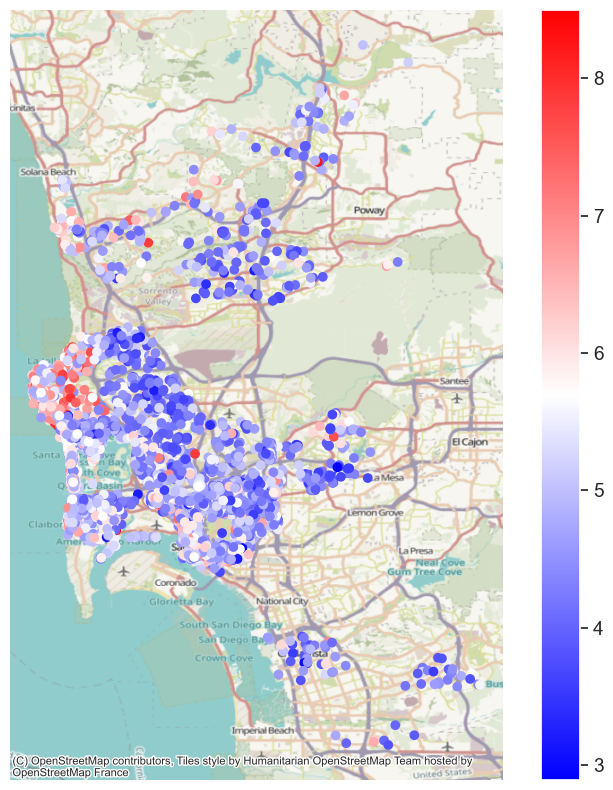

In [194]:
ax = db.plot(column = "log_price", figsize = (10,10), cmap = "bwr", legend = True)
# Add basemap
contextily.add_basemap(ax=ax,crs=db.crs)
# Remove axes
ax.set_axis_off();

## Non-spatial regression, a (very) quick refresh

$$
P_i = \alpha + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

* $P_i$ is the Airbnb price of house $i$

* $X_{ik}$ is a set of covariates $k \in K$ to explain such price (e.g., no. of bedrooms, bathrooms,...)

*  $\beta_k$ desribes how covariate $k$ is related to the price 

* the intercept $\alpha$ is the average house price when all the other variables are zero

* $\epsilon_i$ is the "error" term and captures elements that influence the price of a house but are not included in $X$

For a quick recap of the intuition of regression modeling, see e.g. [this video](https://www.youtube.com/watch?v=PaFPbb66DxQ). For a more formal and thorough coverage, I recommend _Wooldridge (2019), Introductory Econometrics: A Modern Approach (Part 1)._

Before we discuss how to explicitly include space into the linear regression framework, let us show how basic regression can be carried out in Python, and how one can begin to interpret the results. By no means is this a formal and complete introduction to regression so, if that is what you are looking for, we recommend [Gelman_2006](http://dx.doi.org/10.1017/cbo9780511790942), in particular chapters 3 and 4, which provide a fantastic, non-spatial introduction.

The core idea of linear regression is to explain the variation in a given (*dependent*) variable as a linear function of a collection of other (*explanatory*) variables. For example, in our case, we may want to express the price of a house as a function of the number of bedrooms it has and whether it is a condominium or not. At the individual level, we can express this as:

$$
P_i = \alpha + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

where $P_i$ is the Airbnb price of house $i$, and $X$ is a set of covariates that we use to explain such price (e.g., No. of bedrooms and condominium binary variable). $\beta$ is a vector of parameters that give us information about in which way and to what extent each variable is related to the price, and $\alpha$, the constant term, is the average house price when all the other variables are zero. The term $\epsilon_i$ is usually referred to as "error" and captures elements that influence the price of a house but are not included in $X$. We can also express this relation in matrix form, excluding sub-indices for $i$, which yields:

$$
P = \alpha + \mathbf{X}\beta + \epsilon
$$

A regression can be seen as a multivariate extension of bivariate correlations. Indeed, one way to interpret the $\beta_k$ coefficients in the equation above is as the degree of correlation between the explanatory variable $k$ and the dependent variable, *keeping all the other explanatory variables constant*. When one calculates bivariate correlations, the coefficient of a variable is picking up the correlation between the variables, but it is also subsuming into it variation associated with other correlated variables -- also called confounding factors. Regression allows us to isolate the distinct effect that a single variable has on the dependent one, once we *control* for those other variables.



## Non-spatial regression in Python

Practically speaking, linear regressions in Python are rather streamlined and easy to work with. There are also several packages which will run them (e.g., `statsmodels`, `scikit-learn`, `pysal`). 



In the context of this chapter, it makes sense to start with `spreg`, as that is the only library that will allow us to move into explicitly spatial econometric models.

In [195]:
from pysal.model import spreg

In [196]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    y= db[["log_price"]].values,
    # Independent variables
    x = db[variable_names].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variable_names,
)

* We use the command `OLS`, part of the `spreg` sub-package, and specify the dependent variable (the __log of the price__, so we can interpret results in terms of percentage change in the dependent variable for a one-unit change in the independent variable) and the explanatory ones. 

* Note that both objects need to be arrays, so we extract them from the `pandas.DataFrame` object using `.values`.



In order to inspect the results of the model, we can print the `summary` attribute:

In [197]:
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:     1320.15                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

------------------------------------------------------------

A full detailed explanation of the output is beyond the scope of this chapter, so we will focus on the relevant bits for our main purpose. This is concentrated on the `Coefficients` section, which gives us the estimates for $\beta_k$ in our model. In other words, these numbers express the relationship between each explanatory variable and the dependent one, once the effect of confounding factors has been accounted for. Keep in mind however that regression is no magic; we are only discounting the effect of confounding factors that we include in the model, not of *all* potentially confounding factors.

Results are largely as expected:  houses tend to be significantly <span style="color:green">more expensive </span>if they accommodate <span style="color:green">more people (`accommodates`)</span>, if they have <span style="color:green">more bathrooms and bedrooms</span>, and if they are a <span style="color:green">condominium</span> or part of the <span style="color:green">"other" category</span> of house type. Conversely, given a number of rooms, houses with <span style="color:red">more beds</span> (i.e., listings that are more "crowded") tend to go for cheaper, as it is the case for properties where one does not rent the entire house but only a <span style="color:red">room (`rt_Private_room`)</span> or even <span style="color:red"> shares it (`rt_Shared_room`)</span>. Of course, you might conceptually doubt the assumption that it is possible to *arbitrarily* change the number of beds within an Airbnb without eventually changing the number of people it accommodates, but methods to address these concerns using *interaction effects* won't be discussed here. 


### Hidden structures

In general, our model performs well, being able to predict slightly about two-thirds ($R^2=0.67$) of the variation in the mean nightly price using the covariates we've discussed above.
But, our model might display some __clustering in the errors__, which may be a problem as that violates the i.i.d. assumption linear models usually come built-in with. 




#### Options to analyze spatial structures in the error term
* Split our data up __by regions__ and see if we've got some __spatial structure in our residuals.__ 

 
    * Differing errors by proximity to the beach
    * Differing errors by neighborhood
    * ...

* Look at the __correlation between the error__ in predicting an Airbnb and the __error in predicting its nearest neighbor.__  


One reasonable theory might be that our model does not include any information about *beaches*, a critical aspect of why people live and vacation in San Diego.  Therefore, we might want to see whether or not our errors are higher or lower depending on whether or not an Airbnb is in a "beach" neighborhood, a neighborhood near the ocean. We use the code below to generate Figure XXX1XXX, which looks at prices between the two groups of houses, "beach" and "no beach".

### 1. Spatial proximity to the beach

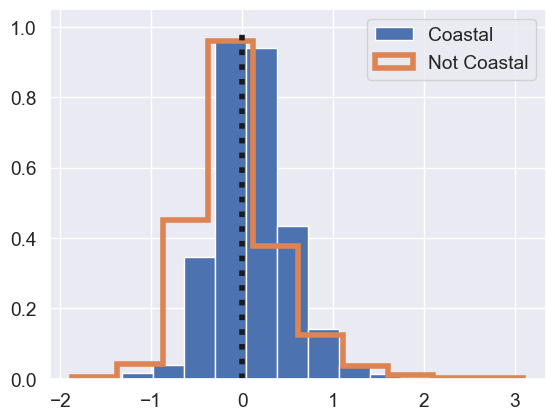

In [198]:
# Create a Boolean (True/False) with whether a
# property is coastal or not
is_coastal = db.coastal.astype(bool)
# Split residuals (m1.u) between coastal and not
coastal = m1.u[is_coastal] #coastal 
not_coastal = m1.u[~is_coastal] #non-coastal ("~" inverts the variable)
# Create histogram of the distribution of coastal residuals
plt.hist(coastal, density=True, label="Coastal")
# Create histogram of the distribution of non-coastal residuals
plt.hist(
    not_coastal,
    histtype="step",
    density=True,
    linewidth=4,
    label="Not Coastal",
)
# Add Line on 0
plt.vlines(0, 0, 1, linestyle=":", color="k", linewidth=4)
# Add legend
plt.legend()
# Display
plt.show()

While it appears that the neighborhoods on the coast have only slightly higher average errors (and have lower variance in their prediction errors), the two distributions are significantly distinct from one another when compared using a classic __$t$-test__:

In [199]:
from scipy.stats import ttest_ind # independent two-sample t-test 

ttest_ind(coastal, not_coastal) # t-test to compare means of 'coastal' and 'not_coastal' groups

TtestResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]), df=array([6108.]))

### 2. Errors by neighborhood

Additionally, it might be the case that some neighborhoods are more desirable than other neighborhoods due to unmodeled latent preferences or marketing. 
For instance, despite its presence close to the sea, living near Camp Pendleton -a Marine base in the North of the city- may incur some significant penalties on area desirability due to noise and pollution. These are questions that domain knowledge provides and data analysis can help us answer.
For us to determine whether this is the case, we might be interested in the full distribution of model residuals within each neighborhood. 

To make this more clear, we'll first sort the data by the median residual in that neighborhood, and then make a boxplot (Fig. XXX2XXX), which shows the distribution of residuals in each neighborhood:

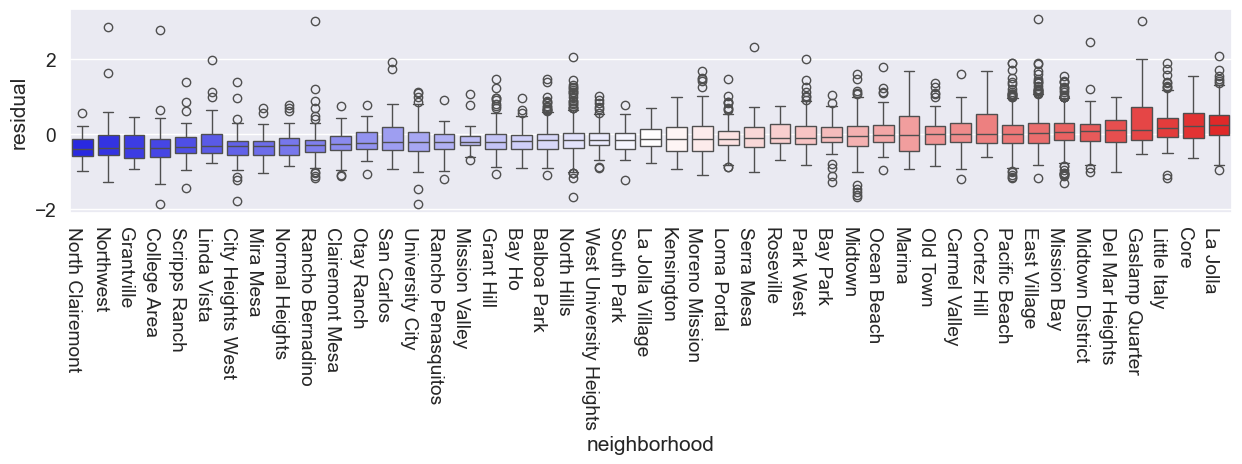

In [200]:
# Create column with residual values from m1
db["residual"] = m1.u
# Obtain the median value of residuals in each neighborhood
medians = (
    db.groupby("neighborhood")
    .residual.median()
    .to_frame("hood_residual")
)

db2 = db.merge(medians, how="left", left_on="neighborhood", right_index=True)

# Increase fontsize
seaborn.set(font_scale=1.25)
# Set up figure
f = plt.figure(figsize=(15, 3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighborhood
# Note the data includes the median values merged on-the-fly
seaborn.boxplot(
    x="neighborhood",
    y="residual",
    ax=ax,
    data=db2.sort_values("hood_residual"),
    hue="neighborhood",
    palette = "bwr"
)
# Rotate the X labels for legibility
f.autofmt_xdate(rotation=-90)
# Display
plt.show()

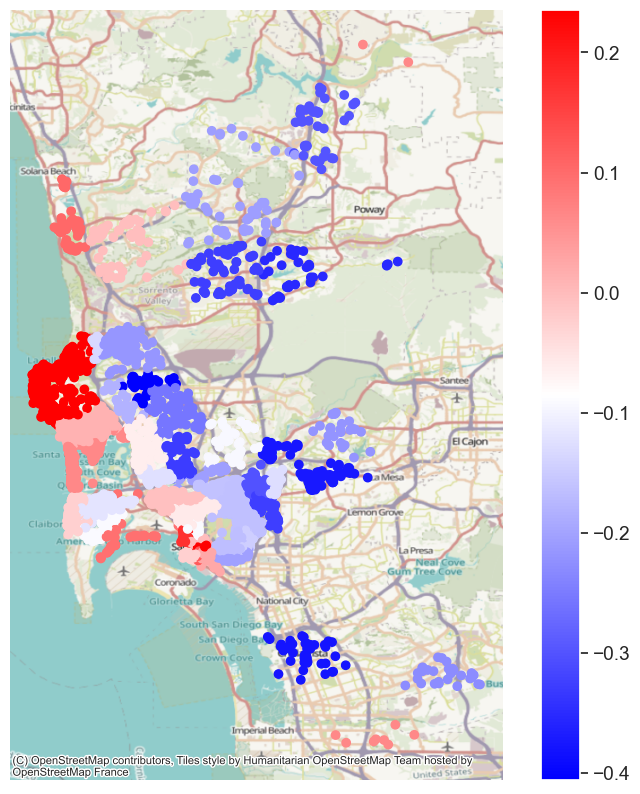

In [201]:
ax = db2.plot("hood_residual", cmap = "bwr", legend = True, figsize=(10,10))
contextily.add_basemap(ax=ax,crs=db2.crs)
ax.set_axis_off()

No neighborhood is disjoint from one another, but some do appear to be higher than others, such as the well-known downtown tourist neighborhoods areas of the Gaslamp Quarter, Little Italy, or The Core. 
Thus, there may be a distinctive effect of intangible neighborhood fashionableness that matters in this model. 

Noting that many of the __most over- and under-predicted neighborhoods are near one another__ in the city, it may also be the case that there is some sort of __*contagion* or spatial spillovers__ in the nightly rent price. 
This often is apparent when individuals seek to price their __Airbnb listings to compete with similar nearby listings.__ 
Since our model is not aware of this behavior, its errors may tend to cluster. 


### 3. Residual vs. Lagged Residual 

One exceptionally simple way we can look into this structure is by examining the relationship between an observation's residuals and its surrounding residuals. 



We use *spatial weights* to represent the geographic relationships between observations. 
* $KNN$ matrix where $k=1$, i.e meaning we're focusing only on the linkages of each Airbnb to their closest other listing.

In [202]:
knn = weights.KNN.from_dataframe(db, k=1)

C:\Users\ggust\anaconda3\envs\sc_gsda_l9\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 1849 disconnected components.
  warnings.warn(message)


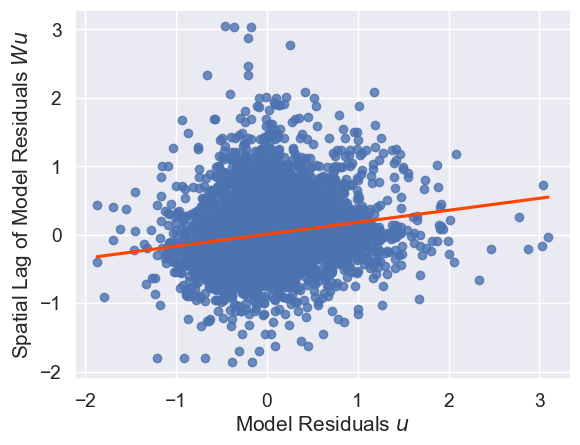

In [203]:
# compute the spatial lag of the vector of residuals
lag_residual = weights.spatial_lag.lag_spatial(w = knn, y = m1.u)
ax = seaborn.regplot(
    x=m1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Model Residuals $u$")
ax.set_ylabel("Spatial Lag of Model Residuals $W u$");

Above, we show the relationship between our prediction error at each site and the prediction error at the site nearest to it. 
Here, we're using this nearest site to stand in for the *surroundings* of that Airbnb. 
This means that, when the model tends __to over-predict a given Airbnb's nightly log price__, sites around that Airbnb are more likely to __*also be over-predicted*.__ An interesting property of this relationship is that it tends to stabilize as the number of nearest neighbors used to construct each Airbnb's surroundings increases.


Examining the relationship between this stable *surrounding* average and the focal Airbnb, we can even find __clusters in our model error__ using the __*local Moran*__ statistics.

### 4. Identify local Hot and Coldspots


In [204]:
# Re-weight W to 20 nearest neighbors
knn.reweight(k=20, inplace=True)
# Row standardize weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)

C:\Users\ggust\anaconda3\envs\sc_gsda_l9\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [205]:
# selects the observations that are in odd quadrants (1 and 3), 
# which typically represent clusters of similar values (e.g., high-high and low-low clusters). 
hot_and_cold = outliers.q % 2 == 1

#filter out insignificant observations
significant = outliers.p_sim <= 0.001  
hot_and_cold  = hot_and_cold  & significant  

#add the info to the dataframe
db3 = db.assign(
        error_clusters=hot_and_cold ,
        local_I=outliers.Is)

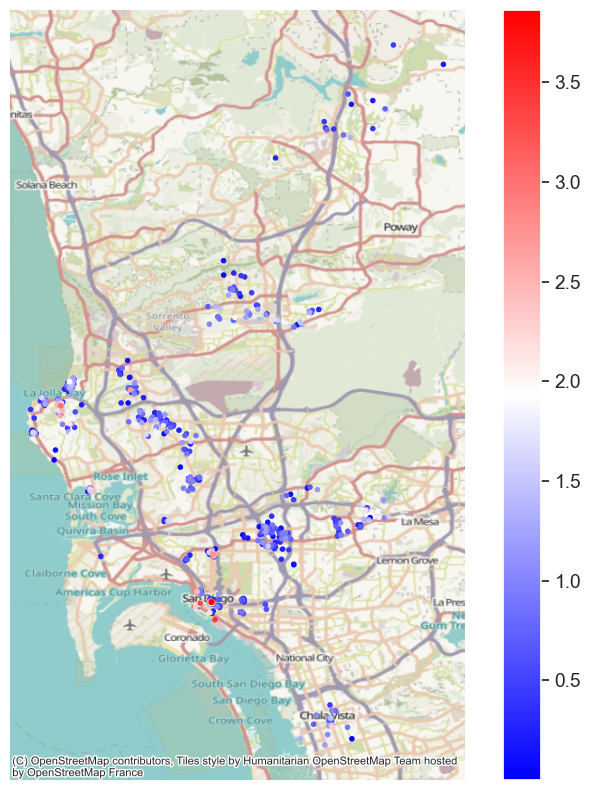

In [206]:
# Add `error_clusters` and `local_I` columns
ax = db3.query("error_clusters").sort_values(
    "local_I"  # Sort by I value to largest plot on top
    ).plot("local_I", cmap="bwr", marker=".", figsize=(10,10), legend = True)   # Plot I values

# Add basemap
contextily.add_basemap(ax, crs=db.crs)
# Remove axes
ax.set_axis_off();

__Significant under- and over-predictions do appear to cluster___ in a highly structured way. 

We might be able to use a __better model to fix the geography of our model errors!__ 

## Bringing space into the regression framework

__Spatial regression__ = introducing __space__ into the __regression model.__



__Two motivations:__

a)  We think space plays an important role in the process 

    Example: We can imagine that houses at the seafront are probably more expensive than those in the second row, given their better views


b)  Space can act as a reasonable proxy for other factors that we cannot but should include in our model
    
    Example: The character of a neighborhood is important in determining the price of a house:
            - However, it is very hard to identify and quantify "character" per se 
            - It might be easier to get its spatial variation, hence a case of space as a proxy.
    

We will study __three approaches__:

### 1) Spatial feature engineering & conventional (non-spatial) regression
### 2) Spatial regression to model spatial heterogeneity
### 3) Spatial regression to model spatial dependence



There are many different ways that spatial structure shows up in our models, predictions, and our data, even if we do not explicitly intend to study it.
Fortunately, there are nearly as many techniques, called *spatial regression* methods, that are designed to handle these sorts of structures.
Spatial regression is about *explicitly* introducing space or geographical context into the statistical framework of a regression. 
Conceptually, we want to introduce space into our model whenever we think it plays an important role in the process we are interested in, or when space can act as a reasonable proxy for other factors that we cannot but should include in our model. 
As an example of the former, we can imagine how houses at the seafront are probably more expensive than those in the second row, given their better views. 
To illustrate the latter, we can think of how the character of a neighborhood is important in determining the price of a house; however, it is very hard to identify and quantify "character" per se, although it might be easier to get at its spatial variation, hence a case of space as a proxy.

Spatial regression is a large field of development in the econometrics and statistics literatures. 
In this brief introduction, we will consider two related but very different processes that give rise to spatial effects: spatial heterogeneity and spatial dependence. Before diving into them, we begin with another approach that introduces space in a regression model without modifying the model itself but rather creates spatially explicit independent variables. 
For more rigorous treatments of the topics introduced here, we refer you to:
* Luc Anselin. Spatial externalities, spatial multipliers, and spatial econometrics. International Regional Science Review, 26(2):153–166, Apr 2003. URL: http://dx.doi.org/10.1177/0160017602250972, doi:10.1177/0160017602250972.
* Luc Anselin and Sergio J. Rey. Modern spatial econometrics in practice: A guide to GeoDa, GeoDaSpace, and PySAL. GeoDa Press, 2014.
* Andrew Gelman and Jennifer Hill. Data Analysis Using Regression and Multilevel Hierarchical Models. Cambridge University Press, 2006. ISBN 9780511790942. URL: http://dx.doi.org/10.1017/cbo9780511790942, doi:10.1017/cbo9780511790942.


### 1) Spatial feature engineering: proximity variables

In this section, we will briefly present how to __insert spatial features__, (= variables that are constructed from geographical relationships), in a __standard linear model.__


__Example__: 
    __Proximity to Balboa Park,__ a common tourist destination, could be an important __*spatially patterned omitted covariate*__: geographic information our model needs to make good predictions which we have left out of our model.

Using geographic information to "construct" new data is a common approach to bring in spatial information into data analysis. Often, this reflects the fact that processes are not the same everywhere in the map of analysis, or that geographical information may be useful to predict our outcome of interest. In this section, we will briefly present how to insert spatial features, or variables that are constructed from geographical relationships, in a standard linear model. Rather than detail, this section will show how spatially explicit variables you engineer can be “plugged” into a model to improve its performance or help you explain the underlying process of interest with more accuracy. 

One relevant proximity-driven variable that could influence our San Diego model is based on the listings proximity to Balboa Park. A common tourist destination, Balboa Park is a central recreation hub for the city of San Diego, containing many museums and the San Diego Zoo. Thus, it could be the case that people searching for Airbnbs in San Diego are willing to pay a premium to live closer to the park. If this were true *and* we omitted this from our model, we may indeed see a significant spatial pattern caused by this distance decay effect. 

Therefore, this is sometimes called a *spatially patterned omitted covariate*: geographic information our model needs to make good predictions which we have left out of our model. Therefore, let's build a new model containing this distance to Balboa Park covariate. First, though, it helps to visualize (Fig. XXX5XXX) the structure of this distance covariate itself:

Luckily the __distance to Balboa Park__ (`d2balboa`, in km) has already been precomputed for us (see [here](https://geographicdata.science/book/data/airbnb/regression_cleaning.html) for how this was done):

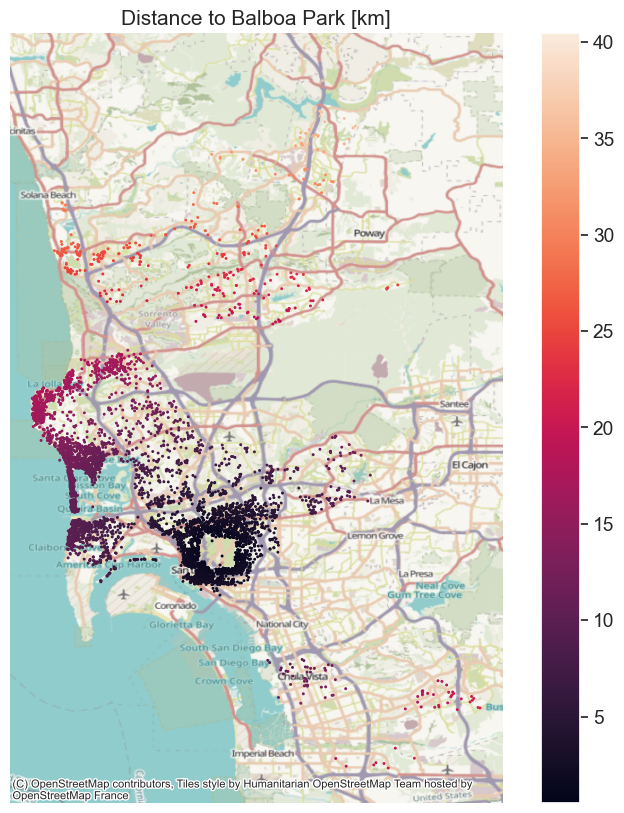

In [207]:
ax = db.plot(column="d2balboa", marker=".", s=5, legend = True, figsize=(10,10))
contextily.add_basemap(ax, crs=db.crs)
ax.set_title("Distance to Balboa Park [km]")
ax.set_axis_off();

To run a linear model that includes the additional variable of distance to the park, we add the name to the list of variables we included originally:

In [208]:
balboa_names = variable_names + ["d2balboa"]

And then fit the model using the OLS class in Pysal's `spreg`:

In [209]:
m2 = spreg.OLS(
    db[["log_price"]].values,
    db[balboa_names].values,
    name_y="log_price",
    name_x=balboa_names,
)

When you inspect the regression diagnostics and output, you see that this covariate is not quite as helpful as we might anticipate:

In [210]:
pandas.DataFrame(
    [[m1.r2, m1.ar2], [m2.r2, m2.ar2]],
    index=["M1", "M2"],
    columns=["R2", "Adj. R2"],
)

,R2,Adj. R2
M1,0.668345,0.667801
M2,0.668502,0.667904


The model fit does not substantially change. `D2Balboa` is not statistically significant at conventional significance levels:

In [211]:
# Set up table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m2.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m2.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m2.t_stat],
    },
    index=m2.name_x,
)

,Coeff.,Std. Error,P-Value
CONSTANT,4.379624,0.016915,0.000000e+00
accommodates,0.083644,0.005079,1.156896e-59
bathrooms,0.190791,0.011005,9.120139e-66
bedrooms,0.150746,0.011179,7.418035e-41
beds,-0.041476,0.006939,2.394322e-09
rt_Private_room,-0.552996,0.015960,2.680270e-240
rt_Shared_room,-1.235521,0.038462,2.586867e-209
pg_Condominium,0.140459,0.022225,2.803765e-10
pg_House,-0.013302,0.014623,3.630396e-01
pg_Other,0.141176,0.022798,6.309880e-10


The distance to Balboa Park variable does not fit our theory about how distance to amenity should affect the price of an Airbnb; the __coefficient estimate__ is __positive__, meaning that people are paying a premium to be further from Balboa Park. 



And, there still appears to be spatial structure in our model's errors, as we can see in the figure below:

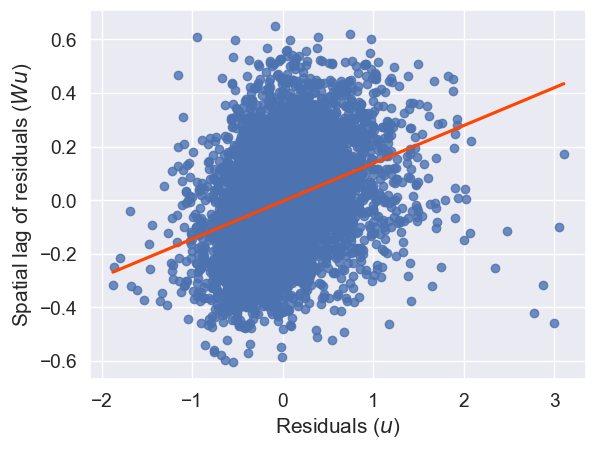

In [212]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
ax = seaborn.regplot(
    x=m2.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

Finally, the distance to Balboa Park variable does not fit our theory about how distance to amenity should affect the price of an Airbnb; the coefficient estimate is *positive*, meaning that people are paying a premium to be *further* from Balboa Park. We will revisit this result later on, when we consider spatial heterogeneity and will be able to shed some light on this. Further, the next chapter is an extensive treatment of spatial fixed effects, presenting many more spatial feature engineering methods. Here, we have only showed how to include these engineered features in a standard linear modeling framework. 

### 2. Spatial regression to model spatial heterogeneity



__Spatial heterogeneity__ means that parts of the model may __vary systematically with geography.__ 


For example, 

* Changes to the __intercept, 𝛼__ may reflect the fact that different areas have different baseline exposures to a given process. 
    * E.g. different AirBNB prices per neighborhood

* Changes to the __slope terms,  𝛽__ may indicate some kind of __geographical mediating factor__ that makes the relationship between the independent and dependent variables vary across space
    * E.g. prices for additional beds increase more strongly in the city center

* Finally, changes to the __variance of the residuals__, commonly denoted __𝜎2__ can introduce __spatial heteroskedasticity.__
    * E.g. higher price levels and thus larger price variations in the city center


We deal with the first two in this lecture.

So far we have assumed that our proximity variable might stand in for a difficult-to-measure premium individuals pay when they're close to a recreational zone (a park in this case). Our approach in that case was to incorporate space through a very specific channel, that is the distance to an amenity we thought might be influencing the final price. However, not all neighborhoods have the same house prices; some neighborhoods may be systematically more expensive than others, regardless of their proximity to Balboa Park. If this is our case, we need some way to account for the fact that each neighborhood may experience these kinds of *gestalt*, unique effects. One way to do this is by capturing *spatial heterogeneity* (SH). At its most basic, *spatial heterogeneity* means that parts of the model may vary systematically with geography, change in different places. For example, changes to the intercept, $\alpha$, may reflect the fact that different areas have different baseline exposures to a given process. Changes to the slope terms, $\beta$, may indicate some kind of geographical mediating factor that makes the relationship between the independent and dependent variables vary across space, such as when a governmental policy is not consistently applied across jurisdictions. Finally, changes to the variance of the residuals, commonly denoted $\sigma^2$, can introduce spatial heteroskedasticity. We deal with the first two in this section. 



### Spatial fixed effects

The literature commonly refers to geographic variations of __$\alpha$ as "spatial fixed effects (FE)".__ 

__Example:__ 
* To illustrate them, let us consider the house price example from the previous section. Sometimes, spatial fixed effects are said to capture __"space as a proxy",__ in that we know the outcome varies over space, we (hope to) know the pattern it follows (in our case, by neighborhood) and we can thus incorporate that knowledge into the model by __letting $\alpha$ vary accordingly.__ 
* The rationale goes as follows. Given we are only including a few explanatory variables in the model, it is likely we are __missing some important factors__ that play a role at determining the price at which a house is sold. Some of them, however, are likely to __vary systematically over space (e.g., by neighborhood characteristics).__  


We can __control for those unobserved factors__ by using traditional binary variables but basing their creation on a spatial rule. 

For example, let us include a binary variable for every neighborhood, indicating whether a given house is located within such area (`1`) or not (`0`). Mathematically, we are now fitting the following equation:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

where the main difference is that we are now __allowing the constant term, $\alpha$, to vary by neighborhood $r$, $\alpha_r$.__

Programmatically, we will show two different ways we can estimate this: one,
using `statsmodels`; and two, with `spreg`. First, we will use `statsmodels`, the econometrician's toolbox in Python. 

#### Excursus (study on your own): Spatial fixed effects using `statsmodels`

In [213]:
import statsmodels.formula.api as sm

This package provides a __formula-like API__, which allows us to express the *equation* we wish to estimate directly:

In [214]:
# Start building a formula string for a statistical model
f = (
    "log_price ~ "  # Set 'log_price' as the dependent variable
    + " + ".join(variable_names)  # Add independent variables from 'variable_names' list
    + " + neighborhood - 1"  # Include 'neighborhood' as an independent variable, exclude intercept
)
print(f)

log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1


The *tilde* operator in this statement is usually read as "log price is a function of ...", to account for the fact that many different model specifications can be fit according to that functional relationship between `log_price` and our covariate list. Critically, note that the trailing `-1` term means that we are fitting this model __without an intercept term.__ This is necessary, since including an intercept term alongside unique means for every neighborhood would make the underlying system of equations underspecified.  



Using this expression, we can estimate the unique effects of each neighborhood, fitting the model in `statsmodels` (note how the specification of the model, formula and data is separated from the fitting step): 

In [215]:
m3 = sm.ols(f, data=db).fit()

We could rely on the `summary()` method to print a similar summary report from the regression but, given it is a lengthy one in this case, we will illustrate how you can extract the spatial fixed effects into a table for display.

In [216]:
# Store variable names for all the spatial fixed effects
sfe_names = [i for i in m3.params.index if "neighborhood[" in i]
# Create table
pandas.DataFrame(
    {
        "Coef.": m3.params[sfe_names],
        "Std. Error": m3.bse[sfe_names],
        "P-Value": m3.pvalues[sfe_names],
    }
)

,Coef.,Std. Error,P-Value
neighborhood[Balboa Park],4.280766,0.033292,0.0
neighborhood[Bay Ho],4.198251,0.076878,0.0
neighborhood[Bay Park],4.329223,0.050987,0.0
neighborhood[Carmel Valley],4.389261,0.056553,0.0
neighborhood[City Heights West],4.053518,0.058378,0.0
neighborhood[Clairemont Mesa],4.095259,0.047699,0.0
neighborhood[College Area],4.033697,0.058258,0.0
neighborhood[Core],4.726186,0.052643,0.0
neighborhood[Cortez Hill],4.608090,0.051526,0.0
neighborhood[Del Mar Heights],4.496910,0.054337,0.0


The approach above shows how spatial FE are a particular case of a linear regression with a categorical  variable. Neighborhood membership is modeled using binary dummy variables. Thanks to the formula grammar used in `statsmodels`, we can express the model abstractly, and Python parses it, appropriately creating binary variables as required.


### The same model using the Spatial Regression Models (`spreg`) package

The second approach leverages `spreg` Regimes functionality. We will see regimes below but, for now, think of them as a generalization of spatial fixed effects where not only $\alpha$ can vary. This framework allows the user to specify which variables are to be estimated separately for each group. In this case, instead of describing the model in a formula, we need to pass each element of the model as separate arguments.

The `spreg` framework allows the user to specify which variables are to be estimated separately for each group, so-called __regime:__
* intercept __𝛼__
* slope terms  __𝛽__
* variance of the residuals __𝜎2__

We start by allowing only the intercept __𝛼__ to vary:

In [217]:
# spreg spatial fixed effect implementation
m4 = spreg.OLS_Regimes(
    # Dependent variable
    y = db[["log_price"]].values,
    # Independent variables
    x = db[variable_names].values,
    # Variable specifying regime membership
    regimes = db["neighborhood"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False] * len(variable_names),
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

Similarly as above, we could rely on the `summary` attribute to print a report with all the results computed. For simplicity here, we will only confirm that, to the 12th decimal, the parameters estimated are indeed the same as those we get from `statsmodels`:

In [218]:
import numpy

numpy.round(m4.betas.flatten() - m3.params.values, decimals=12)

array([-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,
        0.,  0.,  0.])

### Evaluating the neighborhood-fixed effects



First, we extract only the effects pertaining to the neighborhoods:

In [219]:
neighborhood_effects = m3.params.filter(like="neighborhood")
neighborhood_effects.head(10)

neighborhood[Balboa Park]          4.280766
neighborhood[Bay Ho]               4.198251
neighborhood[Bay Park]             4.329223
neighborhood[Carmel Valley]        4.389261
neighborhood[City Heights West]    4.053518
neighborhood[Clairemont Mesa]      4.095259
neighborhood[College Area]         4.033697
neighborhood[Core]                 4.726186
neighborhood[Cortez Hill]          4.608090
neighborhood[Del Mar Heights]      4.496910
dtype: float64

Extract neighborhood names:

In [220]:
# Create a sequence with the variable names without
# `neighborhood[` and `]`
stripped = neighborhood_effects.index.str.strip(
    "neighborhood["
).str.strip("]")
# Reindex the neighborhood_effects Series on clean names
neighborhood_effects.index = stripped
# Convert Series to DataFrame
neighborhood_effects = neighborhood_effects.to_frame("fixed_effect")
# Print top of table
neighborhood_effects.head(10)

,fixed_effect
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518
Clairemont Mesa,4.095259
College Area,4.033697
Core,4.726186
Cortez Hill,4.608090
Del Mar Heights,4.496910


Merge the datasets:

In [221]:
db_fe = db.merge(neighborhood_effects, 
                 how = "left", 
                 left_on = "neighborhood" , 
                 right_index=True)

Create the plot:

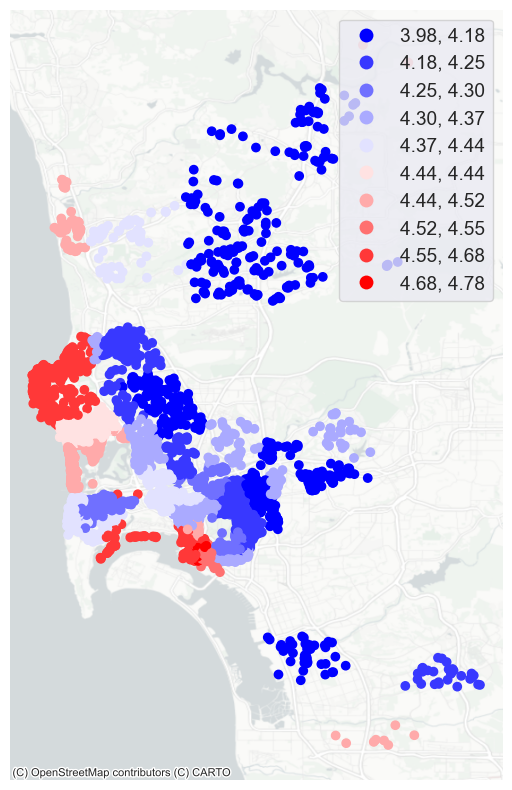

In [222]:
# Plot quantile choropleth
ax = db_fe.plot(
    "fixed_effect",  # Variable to display
    scheme="quantiles",  # Choropleth scheme
    k=10,  # No. of classes in the choropleth
    cmap="bwr",  # Color scheme
    legend = True,
    figsize = (10,10)
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.CartoDB.PositronNoLabels)
# Remove axis
ax.set_axis_off()
# Display
plt.show()

We can see a clear spatial structure in the SFE estimates. The most expensive neighborhoods tend to be located near the coast and in the city center, while the cheapest ones are more inland.

__Question__ (to explore on your own): How do the remaining error terms differ in comparison to the non-spatial model?

### Next Level of spatial regression: Allow for varying slope terms ($\beta_{k-r}$) 

The idea of spatial regimes (SRs) is to generalize the spatial FE approach to allow __not only the constant__ term to vary __but also any other explanatory variable.__ This implies that the equation we will be estimating is:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ki}\beta_{k-r} + \epsilon_i
$$

where we are not only allowing the constant term to vary by region ($\alpha_r$), but also every other parameter ($\beta_{k-r}$).

At the core of estimating spatial FEs is the idea that, instead of assuming the dependent variable behaves uniformly over space, there are systematic effects following a geographical pattern that affect its behavior. In other words, spatial FEs introduce econometrically the notion of spatial heterogeneity. They do this in the simplest possible form: by allowing the constant term to vary geographically. The other elements of the regression are left untouched and hence apply uniformly across space. The idea of spatial regimes (SRs) is to generalize the spatial FE approach to allow not only the constant term to vary but also any other explanatory variable. This implies that the equation we will be estimating is:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ki}\beta_{k-r} + \epsilon_i
$$

where we are not only allowing the constant term to vary by region ($\alpha_r$), but also every other parameter ($\beta_{k-r}$).



### Example: Coastal vs. non-costal neighborhoods

To illustrate this approach, we will use the "spatial differentiator" of whether a house is in a coastal neighborhood or not (`coastal_neig`) to define the regimes. 

The rationale behind this choice is that renting a house close to the ocean might be a strong enough pull that people might be willing to pay at different *rates* for each of the house's characteristics.


To implement this in Python, we use the `OLS_Regimes` class in `spreg`, which does most of the heavy lifting for us:

In [223]:
# Pysal spatial regimes implementation
m5 = spreg.OLS_Regimes(
    # Dependent variable
    y = db[["log_price"]].values,
    # Independent variables
    x = db[variable_names].values,
    # Variable specifying regime membership
    regimes = db["coastal"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Allow all explanatory variables to vary accross regimes
    cols2regi='all', 
    # Don't allow separate sigma coefficients by regime
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

The result can be explored and interpreted similarly to the previous ones. If you inspect the `summary` attribute, you will find the parameters for each variable mostly conform to what you would expect, across both regimes. 


To compare the results, we can plot them side-by-side on a bespoke table :

In [224]:
# Results table
res = pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m5.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m5.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m5.t_stat],
    },
    index=m5.name_x,
)
# Coastal regime
## Extract variables for the coastal regime
coastal = [i for i in res.index if "1_" in i]
## Subset results to coastal and remove the 1_ underscore
coastal = res.loc[coastal, :].rename(lambda i: i.replace("1_", ""))
## Build multi-index column names
coastal.columns = pandas.MultiIndex.from_product(
    [["Coastal"], coastal.columns]
)
# Non-coastal model
## Extract variables for the non-coastal regime
ncoastal = [i for i in res.index if "0_" in i]
## Subset results to non-coastal and remove the 0_ underscore
ncoastal = res.loc[ncoastal, :].rename(lambda i: i.replace("0_", ""))
## Build multi-index column names
ncoastal.columns = pandas.MultiIndex.from_product(
    [["Non-coastal"], ncoastal.columns]
)
# Concat both models
pandas.concat([coastal, ncoastal], axis=1)

Coastal                          Non-coastal             \
                   Coeff. Std. Error       P-Value      Coeff. Std. Error   
CONSTANT         4.479904   0.025094  0.000000e+00    4.407242   0.021516   
accommodates     0.048464   0.007881  8.253761e-10    0.090186   0.006474   
bathrooms        0.247478   0.016566  1.381278e-49    0.143376   0.014268   
bedrooms         0.189740   0.017923  5.783965e-26    0.112963   0.013827   
beds            -0.050608   0.010743  2.522348e-06   -0.026272   0.008838   
rt_Private_room -0.558628   0.028312  4.723759e-84   -0.529334   0.018918   
rt_Shared_room  -1.052854   0.084174  1.836512e-35   -1.224459   0.042597   
pg_Condominium   0.204447   0.033943  1.810152e-09    0.105307   0.028131   
pg_House         0.075353   0.023378  1.274269e-03   -0.045447   0.017957   
pg_Other         0.295485   0.038645  2.394157e-14    0.060753   0.027637   
pg_Townhouse    -0.073508   0.049367  1.365396e-01   -0.010397   0.045673   

                                
                       P-Value  
CONSTANT          0.000000e+00  
accommodates      1.893020e-43  
bathrooms         1.418804e-23  
bedrooms          3.731742e-16  
beds              2.964354e-03  
rt_Private_room  3.546091e-162  
rt_Shared_room   1.657163e-170  
pg_Condominium    1.831822e-04  
pg_House          1.140318e-02  
pg_Other          2.796727e-02  
pg_Townhouse      8.199294e-01

### Key Question:  Statistical significance of regimes?

For this, the model object also calculates for us what is called a __Chow test.__ This is a statistic that tests the __null hypothesis__ that estimates from different regimes are __undistinguishable.__ If we reject the null, we have evidence suggesting the regimes actually make a difference.

Results from the Chow test are available on the `summary` attribute, or we can extract them directly from the model object, which we will do here. 

There are two types of Chow test:

1. __Global test__ that jointly tests for differences between the two regimes:

In [225]:
m5.chow.joint

(328.8690214302763, 7.11354876738264e-64)

The first value represents the statistic, while the second one captures the p-value. In this case, the two regimes are __statistically different__ from each other. 

2.  __Test per coefficient:__ Do coefficients __differ across regimes?__ 

In [226]:
pandas.DataFrame(
    # Chow results by variable
    m5.chow.regi,
    # Name of variables
    index=m5.name_x_r,
    # Column names
    columns=["Statistic", "P-value"],
)

,Statistic,P-value
CONSTANT,4.832180,2.793329e-02
accommodates,16.735685,4.296522e-05
bathrooms,22.671471,1.922004e-06
bedrooms,11.503786,6.945459e-04
beds,3.060313,8.022620e-02
rt_Private_room,0.740097,3.896298e-01
rt_Shared_room,3.308838,6.890820e-02
pg_Condominium,5.057283,2.452265e-02
pg_House,16.792503,4.169771e-05
pg_Other,24.409876,7.786847e-07


As we can see in the table, most variables do indeed differ across regimes, statistically speaking. This points to systematic differences in the data generating processes across spatial regimes.

# Regression models for spatial dependence

## Modeling spatial dependence (vs. spatial heterogeneity)

* Spatial heterogeneity = effects that are __*explicitly linked*__ to geography and that hence cause spatial variation
* Spatial dependence = effect of the __*spatial configuration*__ of the observations

* Example: We might think that the price of a house not only depends on whether it is a townhouse or an apartment, but also on whether it is __surrounded__ by many more townhouses than skyscrapers that have more apartments and are thus stronger competition.



* To capture this we need not only the characteristics of a house, but also of its surrounding ones.

As we have just discussed, SH is about effects of phenomena that are *explicitly linked* to geography and that hence cause spatial variation and clustering. This encompasses many of the kinds of spatial effects we may be interested in when we fit
linear regressions. However, in other cases, our focus is on the effect of the *spatial
configuration* of the observations, and the extent to which that has an effect on the
outcome we are considering. For example, we might think that the price of a house not
only depends on whether it is a townhouse or an apartment, but also on
whether it is surrounded by many more townhouses than skyscrapers with more
apartments. This, we could hypothesize, might be related to the different "look and feel" a
neighborhood with low-height, historic buildings has as compared to one with
modern high-rises. To the extent these two different spatial configurations
enter differently the house price determination process, we will be
interested in capturing not only the characteristics of a house, but also of
its surrounding ones.
This kind of spatial effect is fundamentally different from SH in that is it not related to inherent characteristics of the geography but relates  to the characteristics of the observations in our dataset and, specially, to their spatial
arrangement. We call this phenomenon by which the values of observations are related to each other through distance *spatial dependence*.

### Regression models for spatial dependence

* #### Spatial Lag of X (SLX) model

* #### Spatial error model

* #### Spatial Lag (of Y) model

There are several ways to introduce spatial dependence in an econometric framework, with varying degrees of econometric sophistication (see [Anselin (2002)](https://onlinelibrary.wiley.com/doi/10.1111/j.1574-0862.2002.tb00120.x) for a good overview). Common to all of them however is the way space is formally encapsulated: through *spatial weights matrices ($\mathbf{W}$)*, which we discussed in the lecture on spatial weight matrices. In this section, we consider three ways in which spatial dependence, through spatial weights matrices, can be incorporated in a regression framework. We begin with the "least invasive" one, where we only modify the set of independent variables, and the move into more substantial modifications of the baseline linear model.


### Exogenous effects: The SLX model

In our example case, in addition to including a dummy for the type of house (`pg_XXX`), we can also include the __spatial lag of each type of house.__ This addition implies we are also including as explanatory factor of the price of a given house the proportion  neighboring houses in each type. Mathematically, this implies estimating the following model:

$$
\log(P_i) = \alpha + \sum^{p}_{k=1}X_{ij}\beta_j + \sum^{p}_{k=1}\left(\sum^{N}_{j=1}w_{ij}x_{jk}\right)\gamma_k + \epsilon_i
$$


Let us come back to the house price example we have been working with. So far, we
have hypothesized that the price of a house rented in San Diego through Airbnb can
be explained using information about its own characteristics as well as some 
relating to its location such as the neighborhood or the distance to the main
park in the city. However, it is also reasonable to think that prospective renters
care about the set of neighbors a house has, not only about the house itself, and would
be willing to pay more for a house that was surrounded by certain types of houses, 
and less if it was located in the middle of other types. How could we test this idea?

When it comes to regression, the most straightforward way to introduce spatial dependence between the observations in the data is by 
considering not only a given explanatory variable, but also its spatial lag. Conceptually, this approach falls more within the area of spatial feature engineering, which embeds space in a model through the explanatory variables it uses rather than the functional form of the model, and which we delve into with more detail in [Chapter 12](12_feature_engineering). But we think it is interesting to discuss it in this context for two reasons. First, it provides "intellectual scaffolding" to learn the intuition of building spatial dependence into regression. And second, because it also illustrates how many of the techniques we cover in [Chapter 12](12_feature_engineering) can be embedded in a regression model (and, by extension, in other predictive approaches).

In our example case, in addition to including a dummy for the type of house (`pg_XXX`), we can also include the spatial lag of each type of house. This addition implies we are also including as explanatory factor of the price of a given house the proportion  neighboring houses in each type. Mathematically, this implies estimating the following model:

$$
\log(P_i) = \alpha + \sum^{p}_{k=1}X_{ij}\beta_j + \sum^{p}_{k=1}\left(\sum^{N}_{j=1}w_{ij}x_{jk}\right)\gamma_k + \epsilon_i
$$

where $\sum_{j=1}^N w_{ij}x_{jk}$ represents the spatial lag of the $k$th explanatory variable.
This can be stated in *matrix* form using the spatial weights matrix, $\mathbf{W}$, as:

$$
\log(P_i) = \alpha + \mathbf{X}\beta + \mathbf{WX}\gamma + \epsilon.
$$

This splits the model to focus on two main effects: $\beta$ and $\gamma$. The
$\beta$ effect describes the change in $y_i$ when $X_{ik}$ changes by one. (Since we use the log price as the dependent variable, our $\beta$ coefficients can be interpreted as the percentage change in the price associated with a unit change in the explanatory variable.) The subscript for site $i$ is important here: since we're dealing with a $\mathbf{W}$ matrix, it's useful to be clear about where the change occurs. 

Indeed, this matters for the $\gamma$ effect, which represents the 
*indirect* association of a change in $X_i$ with the house price. This can be conceptualized in two ways. 
First, one could think of $\gamma$ as simply *the association between the price in a given house and a unit change in its average surroundings.*
This is useful and simple. But this interpretation blurs *where* this change
might occur. In truth, a change in a variable at site $i$ will result in a *spillover* to its surroundings:
when $x_i$ changes, so too does the *spatial lag* of any site near $i$. 
The precise size of the change in the lag will depend on the structure of $\mathbf{W}$, and it can be 
different for every site it is connected with. For example, think of a very highly connected "focal" site in a 
row-standardized weight matrix. This focal site will not be strongly affected 
if a neighbor changes by a single unit, since each site only contributes a 
small amount to the lag at the focal site. Alternatively, consider a site with only 
one neighbor: its lag will change by *exactly* the amount its sole neighbor changes.
Thus, to discover the exact indirect effect of a change $y$ caused by the change
at a specific site $x_i$ you would need to compute the *change in the spatial lag*,
and then use that as your *change* in $X$. We will discuss this in the following section. 



Let's evaluate the effect of the surrounding building types ("property groups" `pg`). 

In Python, we can calculate the spatial lag of each variable whose name starts by `pg_`
by first creating a list of all of those names, and then applying `pysal`'s
`lag_spatial` to each of them:

In [227]:
# Select only columns in `db` containing the keyword `pg_`
wx = (
    db.filter(
        like="pg_"
        # Compute the spatial lag of each of those variables
    )
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(knn, y)
        # Rename the spatial lag, adding w_ to the original name
    )
    .rename(
        columns=lambda c: "w_"
        + c
        # Remove the lag of the binary variable for apartments
    )
    .drop("w_pg_Apartment", axis=1)
)

Once computed, we can run the model using OLS estimation because, in this
context, the spatial  lags included do not violate any of the assumptions OLS
relies on (they are essentially additional exogenous variables):

In [228]:
# Merge original variables with the spatial lags in `wx`
slx_exog = db[variable_names].join(wx)
# Fit linear model with `spreg`
m6 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    slx_exog.values,
    # Dependent variable name
    name_y="l_price",
    # Independent variables names
    name_x=slx_exog.columns.tolist(),
)

#### Evaluation

As in the previous cases, printing the `summary` attribute of the model object would show a full report table.

To focus on the aspects that differ from the previous models here, we will only pull out results for the variables for which we also included their spatial lags:

In [229]:
# Collect names of variables of interest
vars_of_interest = (
    db[variable_names].filter(like="pg_").join(wx).columns
)
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m6.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m6.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m6.t_stat],
    },
    index=m6.name_x
    # Subset for variables of interest only and round to
    # four decimals
).reindex(vars_of_interest).round(4)

,Coeff.,Std. Error,P-Value
pg_Condominium,0.1063,0.0222,0.0000
pg_House,0.0328,0.0157,0.0368
pg_Other,0.0862,0.0240,0.0003
pg_Townhouse,-0.0277,0.0338,0.4130
w_pg_Condominium,0.5928,0.0690,0.0000
w_pg_House,-0.0774,0.0319,0.0152
w_pg_Other,0.4851,0.0551,0.0000
w_pg_Townhouse,-0.2724,0.1223,0.0260


#### Interpretation:

* The spatial lag of each type of property (`w_pg_XXX`) is the new addition. We observe that, except for the case of townhouses (same as with the binary variable, `pg_Townhouse`), they are __all significant,__ suggesting our initial hypothesis on the role of the surrounding houses might indeed be at work here. 
* The direct effect of the `pg_Condominium` variable means that condominiums are typically 11% more expensive ($\beta_{pg\_{Condominium}}=0.1063$) than the benchmark property type, apartments. 
* More relevant to this section, any given house surrounded by condominiums __*also*__ receives a price premium. 

    (But, since $pg_{Condominium}$ is a dummy variable, the spatial lag at site $i$ represents the *percentage* of properties near $i$ that are condominiums, which is between $0$ and $1$. So, a *unit* change in this variable means that you would increase the condominium percentage by 100%. Thus, a $.1$ increase in `w_pg_Condominium` (a change of ten percentage points) would result in a 5.92% increase in the property house price ($\beta_{w_pg\_Condominium} = 0.6$).)



Introducing a spatial lag of an explanatory variable, as we have just seen, is the most straightforward way of incorporating the notion of spatial dependence in a linear regression framework. It does not require additional changes, it can be estimated with OLS, and the interpretation is rather similar to interpreting non-spatial variables, so long as aggregate changes are required. 

The field of spatial econometrics however is a much broader one and has produced over the last decades many techniques to deal with spatial effects and spatial dependence in different ways. Although this might be an over-simplification, one can say that most of such efforts for the case of a single cross-section are focused on two main variations: the spatial lag and the spatial error model. Both are similar to the case we have seen in that they are based on the introduction of a spatial lag, but they differ in the component of the model they modify and affect.


## Spatial error model





The spatial error model includes a spatial lag in the *error* term of the equation:

$$
\log{P_i} = \alpha + \sum_k \beta_k X_{ki} + \lambda u_{lag-i} + \epsilon_i
$$


$$
u_{lag-i} = \sum_j w_{i,j} u_j. 
$$

Although it appears similar, this specification __violates the assumptions about the
error term in a classical OLS model.__ 

Hence, alternative estimation methods are required. 


Pysal incorporates functionality to estimate several of the most advanced techniques developed by the literature on spatial econometrics. For example, we can use a general method of moments that account for heteroskedasticity ([Arraiz et al 2010](https://onlinelibrary.wiley.com/doi/10.1111/j.1467-9787.2009.00618.x)): 

In [230]:
# Fit spatial error model with `spreg`
# (GMM estimation allowing for heteroskedasticity)
m7 = spreg.GM_Error_Het(
    # Dependent variable
    y = db[["log_price"]].values,
    # Independent variables
    x = db[variable_names].values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

### Evaluation

Similarly as before, the `summary` attribute will return a full-featured table of results. For the most part, it may be interpreted in similar ways to those above. 

The main difference is that, in this case, we can also recover an estimate and inference for the __$\lambda$ parameter__ in the error term:

In [231]:
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m7.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m7.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m7.z_stat],
    },
    index=m7.name_x
    # Subset for lambda parameter and round to
    # four decimals
).reindex(["lambda"]).round(4)

,Coeff.,Std. Error,P-Value
lambda,0.6449,0.0187,0.0


## Spatial lag (of Y) model

The spatial lag model introduces a spatial lag of the *dependent* variable. In the example we have covered, this would translate into:

$$
\log{P_i} = \alpha + \rho \log{P_{lag-i}} + \sum_k \beta_k X_{ki} + \epsilon_i
$$


Although it might not seem very different from the previous equation, this model violates 
the __exogeneity assumption,__ crucial for OLS to work. 

Put simply, this occurs when $P_i$ exists on both "sides" of the equals sign.
In theory, since $P_i$ is included in computing $P_{lag-i}$, exogeneity is violated. 


Similarly to the case of the spatial error, several techniques have been proposed to overcome this
limitation, and Pysal implements several of them (In the example below, we use a two-stage least squares estimation, where the spatial lag of all the explanatory variables is used as instrument for the endogenous lag):

In [232]:
# Fit spatial lag model with `spreg`
# (GMM estimation)
m8 = spreg.GM_Lag(
    # Dependent variable
    y = db[["log_price"]].values,
    # Independent variables
    x = db[variable_names].values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

And let's summarize the coefficients in a table as before (usual disclaimer about the `summary` object applies):

In [233]:
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m8.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m8.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m8.z_stat],
    },
    index=m8.name_z
    # Round to four decimals
).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,2.7440,0.0727,0.0000
accommodates,0.0698,0.0048,0.0000
bathrooms,0.1627,0.0104,0.0000
bedrooms,0.1604,0.0105,0.0000
beds,-0.0365,0.0065,0.0000
rt_Private_room,-0.4981,0.0151,0.0000
rt_Shared_room,-1.1157,0.0366,0.0000
pg_Condominium,0.1073,0.0209,0.0000
pg_House,-0.0004,0.0137,0.9766
pg_Other,0.1208,0.0215,0.0000


Similarly to the effects in the SLX regression, changes in the spatial lag regression need to be interpreted with care. Here, `W_log_price` applies consistently over all observations and actually changes the effective strength of each of the $\beta$ coefficients. Thus, it is useful to use predictions and scenario-building to predict $y$ when changing $X$, which allows you to analyze the *direct* and *indirect* components. 

#### Other ways of bringing space into regression

* __Generalized Additive Models__ have been used to apply spatial kernel smoothing directly within a regression function

* __Spatial Gaussian Process Models__ or Kriging, conceptualize the dependence between locations as smooth as well

* Models for Graph-based geographies

* Extensions to other models e.g. __spatial decision trees__ and __spatial random forests__

See e.g. [here](https://doi.org/10.1111/j.1467-9868.2008.00663.x) for more (advanced text).


#### Other ways of bringing space into regression

We have covered here only a few ways to formally introduce space in a regression framework. There are however many other advanced spatial regression methods routinely used in statistics, data science, and applied analysis. For example, Generalized Additive Models {cite}`Gibbons_2015,Wood_2006` have been used to apply spatial kernel smoothing directly within a regression function. Other similar smoothing methods, such as spatial Gaussian Process Models {cite}`Brunsdon_2010` or Kriging, conceptualize the dependence between locations as smooth as well. Other methods in spatial regression that consider graph-based geographies (rather than distance/kernel effects) include variations on conditional autoregressive model, which examines spatial relationships at locations *conditional* on their surroundings, rather than as jointly co-emergent with them. Full coverage of these topics is beyond the scope of this book, however, though {cite}`Banerjee_2008` provides a detailed and comprehensive discussion. We have not covered these (and other existing ones) not because we do not think are important or useful, far from it, but because we consider them a bit more advanced than the level at which we wanted to pitch the chapter.

Both sets of models we have introduced in here and others that exist but that we have not covered share the feature of embedding space as a "first class" citizen in the regression framework. In all these cases, we conceptualize space (e.g., through a spatial weights matrix) and _modify_ the functional form of our original model in a way that recognizes the location of its observations when generating predictions or inference. This approach results in modifications of the modeling framework to accommodate geography. In the next chapter, we discuss a different perspective to embed space in our modeling efforts. Rather than injecting space through the functional form, we will do it through the variables we use to explain/predict the outcome of interest. In this case, we will be using geography to _enrich_ our data _before_ it is passed through a modeling framework.

## Next steps 

For additional reading on the topics covered in this chapter, please consult the following resources: 

For a more in-depth discussion of the fundamentals of spatial econometrics and applications in both GUI and command-line software, consult:

Anselin, Luc and Sergio Rey. 2014. *Modern Spatial Econometrics in Practice: A Guide to GeoDa, GeoDaSpace, and Pysal.* GeoDa Press. 

For additional mathematical detail and more extensive treatment of space-time models, consult: 

Cressie, Noel and Christopher N. Wikle. 2011. *Statistics for Spatio-Temporal Data*. Singapore: Wiley Press. 

For an alternative perspective on regression and critique of the spatial econometric perspective, consider:

Gibbons, Stephen and Henry G. Overman. 2012. "Mostly Pointless Spatial Econometrics." *Journal of Regional Science* 52: 172-191. 

And for a useful overview of the discussions around multi-level modeling, with references therein to further resources, consider: 

Owen, Gwilym, Richard Harris, and Kelvyn Jones. "Under Examination: Multilevel models, geography and health research." *Progress in Human Geography* 40(3): 394-412. 


<img src="images/d3.png" style="width:50%; float:center;" />
